# Decision trees to select winning alg from the top ~5 algs

Here we ask "which of these 5 algs performs the best on each dataset? 

We only consider datasets where these is no tie between these

In [1]:
# these are the algs to consider in the decision tree
selected_algs = [
    "CatBoost",
    "XGBoost",
    "ResNet",
    "LightGBM",
    "NODE",
    "SAINT",
]

In [2]:
# get tuned alg results & metafeatures for each split separately

import pandas as pd
import numpy as np
from pathlib import Path

from analysis_utils import process_metafeatures

# keep sected feature types
# None = keep all feature types 
filter_families = [
    'general',
    'statistical',
    'model-based',
    'landmarking',
    'info-theory',
]
#     'relative',
#     'clustering',
#     'complexity',
# ]

metadataset_df = pd.read_csv("./cleaned_results/tuned_fold_results.csv")
metafeatures_df = pd.read_csv(Path("../../TabSurvey/metafeatures.csv"))

processed_metafeatures = process_metafeatures(metafeatures_df, filter_families=filter_families)

/Users/duncan/research/active_projects/tabzilla/tabzilla_analysis/final-template/analysis_utils.py:112: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  metafeatures_processed = metafeatures_df.fillna(metafeatures_df.median())


### Bookkeeping for metafeatures

Drop NaNs cols and shorten feature names

In [3]:
# drop cols that are all NaN

na_feats = processed_metafeatures.isna().sum() == len(processed_metafeatures)
na_feat_names = list(na_feats[na_feats].index)
print(f"dropping cols with only NA: {na_feat_names}")
processed_metafeatures.drop(columns=na_feat_names, inplace=True)

# replace inf with something else
processed_metafeatures.replace([np.inf, -np.inf], 0.0, inplace=True)

all_feature_cols = [c for c in processed_metafeatures.columns if c.startswith("f__")]

def simplify(x):
    return x.replace("statistical", "stat").replace("model-based", "model").replace("landmarking", "landmark").replace("skewness", "skew")

nice_feature_names = [simplify(f[len("f__pymfe."):]) for f in all_feature_cols]

dropping cols with only NA: ['f__pymfe.statistical.iq_range', 'f__pymfe.statistical.t_mean']


## Take only selected algs

Determine which of the selected algs wins for each dataset. Drop any dataset with ties.

In [4]:
select_df = metadataset_df.loc[metadataset_df["alg_name"].isin(selected_algs), :]

In [5]:
metric_rank = "Log Loss_rank"
metric = "normalized_Log Loss__test"

# get a df with all metrics for each alg
alg_metrics = select_df.pivot(index="dataset_fold_id", columns="alg_name", values=metric).reset_index()

alg_rank = select_df.groupby(["dataset_fold_id", "alg_name"])[metric_rank].min().unstack(level=-1)
best_rank = select_df.groupby("dataset_fold_id")[metric_rank].min().rename("best_rank").reset_index()

# get best (min) metric
best_metric = select_df.groupby("dataset_fold_id")[metric].min().rename("best_metric").reset_index()

rank_df = alg_rank.merge(best_rank, on="dataset_fold_id", how="inner") \
    .merge(best_metric, on="dataset_fold_id", how="inner")

# merge in the performance of each selected alg
rank_df = rank_df.merge(alg_metrics, on="dataset_fold_id", how="inner", suffixes=("", f" {metric}"))

assert len(alg_rank) == len(best_rank)
assert len(rank_df) == len(best_rank)

for alg_name in selected_algs:
    rank_df.loc[:, f"{alg_name}_wins"] = rank_df[alg_name] == rank_df["best_rank"]

rank_df.loc[:, "multiple_wins"] = rank_df.apply(lambda x: sum(x[a + "_wins"] for a in selected_algs) > 1, axis=1)

In [6]:
# how many ties? 
rank_df["multiple_wins"].sum() / len(rank_df)

0.0

### Create the outcome label (which alg wins?)

In [7]:
rank_df.loc[:, "which_alg_wins"] = "NA"
rank_df.loc[rank_df["multiple_wins"], "which_alg_wins"] = "multiple"
for a in selected_algs:
    only_a_wins = (rank_df[a + "_wins"].astype(int) - rank_df["multiple_wins"].astype(int)) == 1
    rank_df.loc[only_a_wins, "which_alg_wins"] = a

print(rank_df["which_alg_wins"].value_counts())

XGBoost     359
CatBoost    332
LightGBM    291
SAINT       289
ResNet      285
NODE         34
Name: which_alg_wins, dtype: int64


## merge performance dataset with metafeatures

In [8]:
# merge dataset features
df = rank_df.merge(processed_metafeatures, left_on="dataset_fold_id", right_on="dataset_name", how="left")

# Predict outcome: Which of the selected algs performs best?

In [9]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

y_label = df["which_alg_wins"]
y = label_encoder.fit_transform(y_label)

# only keep some features
keep_features = [c for c in all_feature_cols if "hist" not in c]
x = df[keep_features].values.clip(-1e10, 1e10)

## Leave-one-dataset-familiy-out validation of simple classifiers

### Define dataset families

In [10]:
# define dataset family
df.loc[:, "dataset_family"] = df["dataset_name"].apply(lambda x: x[:-len("__fold_x")])

# create a train/val split based on dataset family.
dataset_families = list(df['dataset_family'].unique())
print(f"number of dataset families: {len(dataset_families)}")

number of dataset families: 159


### Define classifiers

In [11]:
# define functions to create base classifiers
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

def get_xgb_clf():
    return XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")

def get_tree_clf():
    return DecisionTreeClassifier(max_depth=3, min_samples_leaf=10)

/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Loop over each dataset family

In [12]:
from sklearn import metrics

# save the trained model & results from each split
model_dict = {
    "xgb": [],
    "tree": [],
}

# save the predictions in vectors with same length of dataframe
xgb_predicted_labels = np.full((len(df), ), None)
tree_predicted_labels = np.full((len(df), ), None)

xgb_predict_proba = np.full((len(df), len(label_encoder.classes_)), None)
tree_predict_proba = np.full((len(df), len(label_encoder.classes_)), None)

for i, val_family in enumerate(dataset_families):

    if i % 10 == 0:
        print(f"fold {i+1} of {len(dataset_families)}")

    val_inds = df["dataset_family"] == val_family
    train_inds = ~val_inds

    # get x and y for the meta-learner
    x_train = x[train_inds, :]
    x_val = x[val_inds, :]

    y_train = y[train_inds]
    y_val = y[val_inds]

    # get the log loss for the ground truth (best) alg
    best_performance_val = df["best_metric"].values[val_inds]
    catboost_performance_val = df[f"CatBoost {metric}"].values[val_inds]

    #####################
    # fit the meta-models

    xgb_clf = get_xgb_clf().fit(x_train, y_train)
    tree_clf = get_tree_clf().fit(x_train, y_train)

    model_dict["xgb"].append(xgb_clf)
    model_dict["tree"].append(tree_clf)

    ####################
    # assess meta-models 

    # save predictions
    xgb_predicted_labels[val_inds] = xgb_clf.predict(x_val)
    tree_predicted_labels[val_inds] = tree_clf.predict(x_val)

    xgb_predict_proba[val_inds, :] = xgb_clf.predict_proba(x_val)
    tree_predict_proba[val_inds, :] = tree_clf.predict_proba(x_val)


fold 1 of 159
fold 11 of 159
fold 21 of 159
fold 31 of 159
fold 41 of 159
fold 51 of 159
fold 61 of 159
fold 71 of 159
fold 81 of 159
fold 91 of 159
fold 101 of 159
fold 111 of 159
fold 121 of 159
fold 131 of 159
fold 141 of 159
fold 151 of 159


### TBD: Evaluate the model

In [13]:
# TBD
# - meta-learner accuracy
# - comparing selected learner to Best Model, and CatBoost

# TBD: Fit model to entire dataset and create tree visual

In [23]:
PLOT_LABELS = [info["category"] for info in keep_algs.values()]
COLORS = [info["color"] for info in keep_algs.values()]
def plot_bar(data_dict, ax):

    # fig, ax = plt.subplots(figsize=(2.5, 2))
    data = []
    for l in PLOT_LABELS:
        if l in data_dict:
            data.append(data_dict[l])
        else:
            data.append(0)
    y_pos = np.arange(len(data))

    # only color the winning alg
    lose_color = "lightgray"
    plot_colors = [lose_color for _ in data]
    winning_idx = np.argmax(data)
    plot_colors[winning_idx] = COLORS[winning_idx]

    hbars = ax.barh(y_pos, data, color=plot_colors)

    ax.set_title(PLOT_LABELS[winning_idx], color=COLORS[winning_idx], fontweight="bold")

    barlabels = ax.bar_label(hbars, fmt='%d', label_type="edge")

    for i, d in enumerate(data):
        if d == max(data):
            barlabels[i].set_font_properties({'weight': "bold"})
        if d < 5:
            ax.text(x=9, 
                    y=y_pos[i] - 0.1, 
                    s=f"{d:3d}",
                    horizontalalignment='right',
                    )
        # if d > 500:
            # barlabels[i].set_label_type({'size': 30})

    # # access Daniel's label and change properties
    # barlabels[-1].set_font_properties({'size': 30})
    # barlabels[-1].set_color('#E34234')

    # ax.set_xlim(right=15)
    ax.set_yticks(y_pos, labels=PLOT_LABELS)

    # plt.show()

leaf: 3
leaf: 4
leaf: 6
leaf: 7
leaf: 10
leaf: 11
leaf: 13
leaf: 14


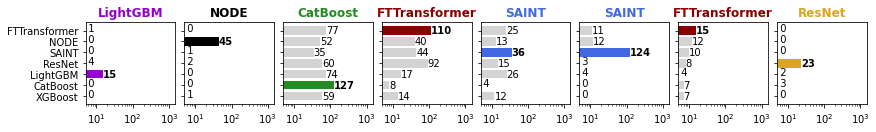

In [24]:
# for each leaf node, plot a pie chart 

predicted_leaves = clf_display.apply(x)
all_leaves = list(set(predicted_leaves))
fig, ax = plt.subplots(nrows=1, ncols=len(all_leaves), figsize=(14, 1.5), sharey=True, sharex=True)

for i, leaf in enumerate(all_leaves):
    print(f"leaf: {leaf}")

    leaf_idx = predicted_leaves == leaf

    # get count of  each true label
    labels = y[leaf_idx]

    counts_dict = pd.value_counts(labels).to_dict()

    plot_bar(counts_dict, ax[i])
    ax[i].set_xscale("log")

ax[0].set_xlim(5, 1.5e3)
    # print()

# plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
# plt.show()
# plt.savefig("tree_leaves.png", bbox_inches="tight", dpi=800)
plt.savefig("tree_leaves.pdf", bbox_inches="tight")

# TODO: make image training on full metadataset, and evaluate on leave-one-out 
# TODO: report performance of selected alg, compared with XGB or CatBoost